### Gluon Implementation in Recurrent Neural Networks

In [1]:
import d2l
import math
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn, rnn

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### Define the Model

In [2]:
num_hiddens = 256
rnn_layer = rnn.RNN(num_hiddens)
rnn_layer.initialize()

Then, we call the `rnn_layer`'s member function `begin_state` to return hidden state list for initialization. It has an element of the shape (number of hidden layers, batch size, number of hidden units).

In [3]:
batch_size = 1
state = rnn_layer.begin_state(batch_size=batch_size)
len(state), state[0].shape

(1, (1, 1, 256))

### RNN Layer in Action

In [4]:
num_steps = 1
X = nd.random.uniform(shape=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

((1, 1, 256), 1, (1, 1, 256))

### RNN Block

In [5]:
class RNNModel(nn.Block):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = nn.Dense(vocab_size)

    def forward(self, inputs, state):
        X = nd.one_hot(inputs.T, self.vocab_size)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of Y to
        # (num_steps * batch_size, num_hiddens)
        # Its output shape is (num_steps * batch_size, vocab_size)
        output = self.dense(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

### Prediction 

In [6]:
def predict(prefix, num_predicts, model, vocab, ctx):
    state = model.begin_state(batch_size=1, ctx=ctx)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: nd.array([outputs[-1]], ctx=ctx).reshape((1, 1))
    for y in prefix[1:]:  # Warmup state with prefix
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_predicts):  # Predict num_predicts steps
        Y, state = model(get_input(), state)
        outputs.append(int(Y.argmax(axis=1).reshape(1).asscalar()))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Prediction with Garbage Parameters

In [7]:
ctx = d2l.try_gpu()

model = RNNModel(rnn_layer, len(vocab))
model.initialize(force_reinit=True, ctx=ctx)
predict('time traveller', 10, model, vocab, ctx)

'time travellerlonu gmgmz'

We need to clip gradients to avoid divergence in optimization.

In [8]:
def grad_clipping(model, theta):
    if isinstance(model, gluon.Block):
        params = [p.data() for p in model.collect_params().values()]
    else:
        params = model.params
    norm = math.sqrt(sum((p.grad ** 2).sum().asscalar() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [9]:
def train_epoch(model, train_iter, loss, updater, ctx, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # loss_sum, num_examples
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize state when either it's the first iteration or
            # using random sampling.
            state = model.begin_state(batch_size=X.shape[0], ctx=ctx)
        else:
            for s in state: s.detach()
        y = Y.T.reshape((-1,))
        X, y = X.as_in_context(ctx), y.as_in_context(ctx)
        with autograd.record():
            py, state = model(X, state)
            l = loss(py, y).mean()
        l.backward()
        grad_clipping(model, 1)
        updater(batch_size=1)  # Since used mean already.
        metric.add(l.asscalar() * y.size, y.size)
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [10]:
def train(model, train_iter, vocab, lr, num_epochs, ctx,
              use_random_iter=False):
    # Initialize
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[1, num_epochs])
    if isinstance(model, gluon.Block):
        model.initialize(ctx=ctx, force_reinit=True, init=init.Normal(0.01))
        trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': lr})
        updater = lambda batch_size : trainer.step(batch_size)
    else:
        updater = lambda batch_size : d2l.sgd(model.params, lr, batch_size)

    prediction = lambda prefix: predict(prefix, 50, model, vocab, ctx)
    # Train and check the progress.
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            model, train_iter, loss, updater, ctx, use_random_iter)
        if epoch % 10 == 0:
            print(prediction('time traveller'))
            animator.add(epoch+1, [ppl])
    print('Perplexity %.1f, %d tokens/sec on %s' % (ppl, speed, ctx))
    print(prediction('time traveller'))
    print(prediction('traveller'))

Train the model using the same hyper-parameters as previously.

Perplexity 1.2, 127052 tokens/sec on gpu(0)
time traveller  it s against reason said filby  what reason said
traveller smiled round at us i wonder what he s got  some s


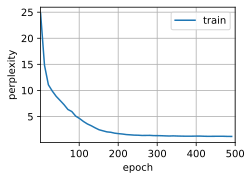

In [11]:
num_epochs, lr = 500, 1
train(model, train_iter, vocab, lr, num_epochs, ctx)